In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from src.settings import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix, get_edges_with_features_filename
from pathlib import Path
import plotly.express as px
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
from src.tools.dim_reduction import reduce_umap
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
from src.tools.aggregation import aggregate_hex
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from pytorch_lightning.loggers import WandbLogger
import wandb
from src.models.autoencoder import LitAutoEncoder
import random
from src.tools.feature_extraction import apply_feature_selection, sparse_dtype
import json5 as json

tqdm.pandas()

In [3]:
random_seed = RANDOM_SEED

torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

In [4]:
cities = pd.read_csv(RAW_DATA_DIR / "cities.csv")
cities = cities[(cities.country == "Poland") & (cities.kacper)]
cities

,city,country,continent,kacper,szymon,piotr,kamil,regions,to_fix
71,Białystok,Poland,Europe,True,False,False,False,NaN,False
72,Bydgoszcz,Poland,Europe,True,False,True,False,NaN,False
73,Częstochowa,Poland,Europe,True,False,False,False,NaN,False
77,Kraków,Poland,Europe,True,True,True,False,NaN,False
78,Lublin,Poland,Europe,True,False,True,False,NaN,False
79,Poznań,Poland,Europe,True,True,True,True,NaN,False
80,Radom,Poland,Europe,True,False,True,False,NaN,False
82,Szczecin,Poland,Europe,True,True,True,False,NaN,False
83,Trójmiasto,Poland,Europe,True,False,True,False,"['Gdańsk','Gdynia','Sopot']",False
84,Warszawa,Poland,Europe,True,True,True,True,NaN,False


In [5]:
with open(RAW_DATA_DIR / "featureset_transformation_default.jsonc", "r") as f:
    featureset = json.load(f)
features_transformation = [f"{k}_{v}" for k, vs in featureset.items() for v in vs]

In [13]:
resolution = 8
buffered = True
network_type = "drive"
intersection_based = False

pbar = tqdm(cities.itertuples(), total=cities.shape[0])
hexagons = []
edges = []
for row in pbar:
    place_name = f"{row.city},{row.country}"
    place_dir_name = get_place_dir_name(place_name)
    place_dir_path = GENERATED_DATA_DIR / place_dir_name
    gpkg_path = place_dir_path / f"graph_{network_type}.gpkg"
    pbar.set_description(place_name)

    try:
        hexagons_city = gpd.read_file(gpkg_path, layer=f"hex_{get_resolution_buffered_suffix(resolution, buffered)}")
        hexagons_city["city"] = row.city
        hexagons_city["country"] = row.country
        hexagons_city["continent"] = row.continent
        hexagons.append(hexagons_city)

        edges_city = gpd.read_feather(place_dir_path / get_edges_with_features_filename(network_type, resolution, buffered, intersection_based))
        edges_city[features_transformation] = edges_city[features_transformation].astype(sparse_dtype)
        edges_city["city"] = row.city
        edges_city["country"] = row.country
        edges_city["continent"] = row.continent
        edges.append(edges_city)
    except Exception as e:
        print("\nFailed", place_name, e)
    

hexagons = gpd.GeoDataFrame(pd.concat(hexagons, ignore_index=True).set_index(["continent", "country", "city", "h3_id"]))
edges = gpd.GeoDataFrame(pd.concat(edges)).set_index(["continent", "country", "city", "h3_id"])
# hex_agg_tfidf = tfidf(hex_agg)

del hexagons_city
del edges_city

Łódź,Poland: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]        


In [17]:
with open(RAW_DATA_DIR / "featureset_selection_1.jsonc", "r") as f:
    featureset_selection_config = json.load(f)
edges_feature_selection = apply_feature_selection(edges, featureset_selection_config)
print("n features:", len(edges_feature_selection.columns))
print(edges_feature_selection.columns)

n features: 80
Index(['oneway_True', 'lanes_1', 'lanes_2', 'lanes_3', 'lanes_4', 'lanes_5',
       'lanes_6', 'lanes_7', 'lanes_8', 'lanes_9', 'lanes_10',
       'highway_living_street', 'highway_motorway', 'highway_motorway_link',
       'highway_primary', 'highway_primary_link', 'highway_residential',
       'highway_secondary', 'highway_secondary_link', 'highway_tertiary',
       'highway_tertiary_link', 'highway_trunk', 'highway_trunk_link',
       'highway_unclassified', 'maxspeed_5', 'maxspeed_7', 'maxspeed_10',
       'maxspeed_15', 'maxspeed_20', 'maxspeed_30', 'maxspeed_40',
       'maxspeed_50', 'maxspeed_60', 'maxspeed_70', 'maxspeed_80',
       'maxspeed_90', 'maxspeed_100', 'maxspeed_110', 'maxspeed_120',
       'maxspeed_130', 'maxspeed_140', 'bridge_yes', 'bridge_cantilever',
       'bridge_covered', 'bridge_low_water_crossing', 'bridge_movable',
       'bridge_viaduct', 'access_no', 'access_permissive', 'access_permit',
       'access_destination', 'access_delivery', 'a

In [28]:
hex_agg = edges_feature_selection.groupby(level=["continent", "country", "city", "h3_id"]).sum()
hex_agg

oneway_True  lanes_1  lanes_2  \
continent country city      h3_id                                            
Europe    Poland  Białystok 881f5104d3fffff            5        2        3   
                            881f5104dbfffff           10        0        7   
                            881f510681fffff           21        4       11   
                            881f510683fffff           56       20       26   
                            881f510685fffff            0        0        0   
...                                                  ...      ...      ...   
                  Łódź      881f5249b1fffff            0        0        0   
                            881f5249b3fffff            0        0        0   
                            881f5249b5fffff            0        0        0   
                            881f5249b7fffff            0        0        0   
                            881f5249bbfffff            0        0        0   

                                             lanes_3  lanes_4  lanes_5  \
continent country city      h3_id                                        
Europe    Poland  Białystok 881f5104d3fffff        2        0        0   
                            881f5104dbfffff        1        0        0   
                            881f510681fffff        0        0        0   
                            881f510683fffff        4        0        0   
                            881f510685fffff        0        0        0   
...                                              ...      ...      ...   
                  Łódź      881f5249b1fffff        0        0        0   
                            881f5249b3fffff        0        0        0   
                            881f5249b5fffff        0        0        0   
                            881f5249b7fffff        0        0        0   
                            881f5249bbfffff        0        0        0   

                                             lanes_6  lanes_7  lanes_8  \
continent country city      h3_id                                        
Europe    Poland  Białystok 881f5104d3fffff        0        0        0   
                            881f5104dbfffff        0        0        0   
                            881f510681fffff        0        0        0   
                            881f510683fffff        0        0        0   
                            881f510685fffff        0        0        0   
...                                              ...      ...      ...   
                  Łódź      881f5249b1fffff        0        0        0   
                            881f5249b3fffff        0        0        0   
                            881f5249b5fffff        0        0        0   
                            881f5249b7fffff        0        0        0   
                            881f5249bbfffff        0        0        0   

                                             lanes_9  ...  width_13.0  \
continent country city      h3_id                     ...               
Europe    Poland  Białystok 881f5104d3fffff        0  ...           0   
                            881f5104dbfffff        0  ...           0   
                            881f510681fffff        0  ...           0   
                            881f510683fffff        0  ...           0   
                            881f510685fffff        0  ...           0   
...                                              ...  ...         ...   
                  Łódź      881f5249b1fffff        0  ...           0   
                            881f5249b3fffff        0  ...           0   
                            881f5249b5fffff        0  ...           0   
                            881f5249b7fffff        0  ...           0   
                            881f5249bbfffff        0  ...           0   

                                             width_14.0  width_15.0  \
continent country city      h3_id                                     
Europe    Po

### TODO add preprocessing (global, local normalization)

In [30]:
test_cities = ["Łódź"]
train_cities = list(set(cities["city"]) - set(test_cities))

X_train = torch.Tensor(hex_agg.drop(index=test_cities, level=2).values)
X_test = torch.Tensor(hex_agg.loc["Europe", "Poland", test_cities].values)

batch_size = 200
num_workers = 5
shuffle = True

X_train_dl = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
X_test_dl = DataLoader(X_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

n_features = X_train.shape[1]

In [32]:
wandb_logger = WandbLogger(log_model=True)
run = wandb.init(project="osm-autoencoder", dir=CHECKPOINTS_DIR, reinit=True)
run_name = run.name
run_dir = PROCESSED_DATA_DIR / run_name
run_dir.mkdir(parents=True, exist_ok=True)

config = wandb.config

hidden_dim = 64
code_dim = 30
epochs = 10
lr = 1e-3

config.random_seed = random_seed
config.featureset_selection_config = featureset_selection_config
config.batch_size = batch_size
config.num_workers = num_workers
config.shuffle = shuffle
config.train_cities = train_cities
config.test_cities = test_cities
config.hidden_dim = hidden_dim
config.code_dim = code_dim
config.epochs = epochs
config.lr = lr

hex_agg.to_pickle(run_dir / "input.pkl.gz")

model = LitAutoEncoder(in_dim=n_features, hidden_dim=hidden_dim, code_dim=code_dim, lr=lr)
trainer = pl.Trainer(gpus=1, max_epochs=epochs, logger=wandb_logger, default_root_dir=CHECKPOINTS_DIR)
trainer.fit(model, train_dataloaders=X_train_dl, val_dataloaders=X_test_dl)

model.eval()
y = model(torch.cat([X_train, X_test]))
y_df = pd.DataFrame(y.detach().numpy()).add_prefix("x_")
del y
y_df.index = hex_agg.index
y_df.to_pickle(run_dir / "embeddings.pkl.gz")

dataset_artifact = wandb.Artifact("dataset", type="dataset")
dataset_artifact.add_dir(run_dir)

wandb.log_artifact(dataset_artifact)

run.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.1 K 
1 | decoder | Sequential | 7.2 K 
---------------------------------------
14.3 K    Trainable params
0         Non-trainable params
14.3 K    Total params
0.057     Total estimated model params size (MB)


d:\Projekty\Programowanie\Studia\Semestr10\gis\osm-road-infrastructure\venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:326: UserWarning: The number of training samples (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  6.98it/s, loss=1.9, v_num=h6xd, train_loss_step=1.950, val_loss_step=0.639, val_loss_epoch=1.410, train_loss_epoch=2.320]  


wandb: Adding directory to artifact (D:\Projekty\Programowanie\Studia\Semestr10\gis\osm-road-infrastructure\data\processed\swift-sea-41)... Done. 0.2s


epoch,▁▁▂▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▇▇███
train_loss_epoch,█▄▃▂▂▂▁▁▁▁
train_loss_step,█▃▂▁
trainer/global_step,▁▁▁▂▁▁▂▂▃▁▁▃▁▁▄▄▄▁▁▄▂▂▂▅▂▂▆▆▂▂▂▇▂▂▇▇█▂▂█
val_loss_epoch,█▅▄▃▃▂▂▁▁▁
val_loss_step,▇█▄▄▅▃▄▄▂▃▄▂▂▃▂▂▃▁▂▂▁▂▂▁▁▂▁▁▂▁
epoch,9
train_loss_epoch,1.93516
train_loss_step,2.17179
trainer/global_step,209
val_loss_epoch,1.41213


In [ ]:
y_df

In [21]:
# from sklearn.preprocessing import normalize
# y_df = pd.DataFrame(normalize(y_df, norm="l2"), columns=y_df.columns, index=y_df.index)  # cosine metric
# y_df["cluster"] = cluster_hdbscan(y_df, min_cluster_size=50, metric="euclidean")[0]
# hexagons_clustered = hexagons.join(y_df).dropna()

In [22]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_clustering = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
y_df["cluster"] = pd.Series(agglomerative_clustering.fit_predict(y_df), index=y_df.index).astype("category")
hexagons_clustered = hexagons.join(y_df).dropna()

<AxesSubplot:>

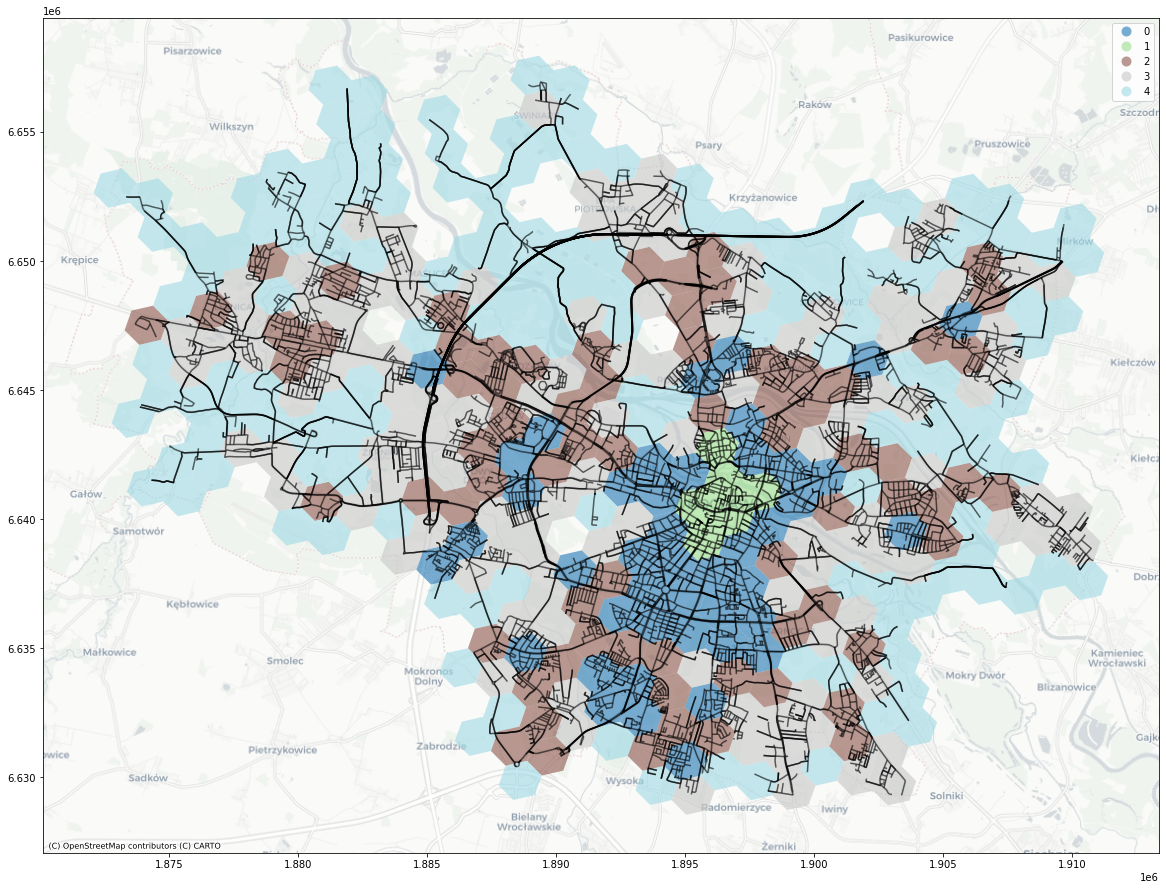

In [23]:
from src.tools.vis_utils import plot_hexagons_map

city = "Wrocław"
plot_hexagons_map(hexagons_clustered[hexagons_clustered["city"] == city], edges[edges["city"] == city], "cluster")

In [24]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from matplotlib import pyplot as plt

# linked = linkage(y_df.drop(columns="cluster").values, method="ward")

# # labelList = range(1, 11)

# plt.figure(figsize=(10, 7))
# dendrogram(linked)
#             # orientation='top',
#             # # labels=labelList,
#             # distance_sort='descending',
#             # show_leaf_counts=True)
# plt.show()

In [25]:
y_df

x_0        x_1        x_2        x_3  \
country city      h3_id                                                         
Poland  Białystok 881f5104d3fffff  -2.385031   0.739146  -2.949323  -0.203480   
                  881f5104dbfffff  -5.898233   5.205915  -0.567436  -3.244496   
                  881f510681fffff -11.460491  -1.542704 -17.529453   0.691282   
                  881f510683fffff -22.607752  25.170271 -23.325727 -15.608296   
                  881f510685fffff  -0.261281   0.321712  -0.093297  -0.218358   
...                                      ...        ...        ...        ...   
        Łódź      881f5249b1fffff  -0.724320   0.539621  -0.631229  -1.776437   
                  881f5249b3fffff  -0.208064  -0.326798  -1.047981  -1.044896   
                  881f5249b5fffff  -1.043652   1.557603  -0.700848  -3.071190   
                  881f5249b7fffff   0.351190  -0.956441  -3.036365  -5.192424   
                  881f5249bbfffff  -1.790442  -0.939488  -5.356576  -6.968368   

                                        x_4       x_5        x_6        x_7  \
country city      h3_id                                                       
Poland  Białystok 881f5104d3fffff -1.284343 -0.318579   1.499786   1.014906   
                  881f5104dbfffff -3.656787 -0.054239   4.850412   5.757464   
                  881f510681fffff  4.332675  6.789072   3.979359   3.369174   
                  881f510683fffff -3.551124 -0.524896  15.861696  35.112732   
                  881f510685fffff -0.185368 -0.029251   0.089311   0.274429   
...                                     ...       ...        ...        ...   
        Łódź      881f5249b1fffff -0.419753  0.780842   0.114454   1.181206   
                  881f5249b3fffff -0.573827  0.617373  -0.067847   1.069085   
                  881f5249b5fffff  0.177724  0.098334   0.146450   1.484195   
                  881f5249b7fffff -0.529538  1.651590  -1.664077   3.103409   
                  881f5249bbfffff -2.091084  4.562739  -2.158790   6.375453   

                                         x_8        x_9  ...       x_21  \
country city      h3_id                                  ...              
Poland  Białystok 881f5104d3fffff  -2.768692  -2.221132  ...  -0.737569   
                  881f5104dbfffff  -3.759911  -6.193037  ...  -1.116266   
                  881f510681fffff -13.013385 -11.166900  ...  12.893346   
                  881f510683fffff -41.919285 -35.855042  ...  13.501730   
                  881f510685fffff  -0.216889  -0.401925  ...   0.271369   
...                                      ...        ...  ...        ...   
        Łódź      881f5249b1fffff  -1.398853  -0.850579  ...   0.937354   
                  881f5249b3fffff  -1.001941  -0.653534  ...   0.246937   
                  881f5249b5fffff  -1.350812  -2.182213  ...   1.667492   
                  881f5249b7fffff  -2.711603  -3.263315  ...   2.633237   
                  881f5249bbfffff  -6.001878  -3.976603  ...   5.159232   

                                       x_22       x_23       x_24       x_25  \
country city      h3_id                                                        
Poland  Białystok 881f5104d3fffff  0.393666   0.142181   1.079046  -3.799632   
                  881f5104dbfffff -3.200576   0.237776   0.441376  -8.841074   
                  881f510681fffff  3.126839  14.731649  12.093080 -22.142044   
                  881f510683fffff -8.987216  15.654839  25.030031 -42.812412   
                  881f510685fffff  0.048971   0.261351   0.404075  -0.352596   
...                                     ...        ...        ...        ...   
        Łódź      881f5249b1fffff -0.623052   1.139166   1.825495  -1.279227   
                  881f5249b3fffff -0.140906   0.983462   1.141098  -1.103898   
                  881f5249b5fffff  0.432429   1.537889   2.684052  -0.928188   
                  881f5249b7fffff -0.409210   3.579198   3.589019  -4.170482   
                  881f5

In [26]:
from src.tools.vis_utils import plot_clusters
embedding = reduce_umap(hex_agg, n_components=2, n_neighbors=30, metric="euclidean")[0]
embedding["cluster"] = y_df["cluster"]
plot_clusters(embedding)

In [27]:
hex_tfidf_by_cluster = hex_agg.join(y_df).groupby(by="cluster")

In [28]:
hex_tfidf_by_cluster_mean = hex_tfidf_by_cluster.mean().reset_index()
hex_tfidf_by_cluster_mean

,cluster,oneway_True,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,lanes_8,...,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29
0,0,36.503155,8.872240,22.709779,8.990536,3.348580,0.405363,0.026814,0.001577,0.0,...,48.354523,15.856525,3.287610,22.523392,23.021614,-39.915207,7.058174,-18.496481,-23.501310,0.448831
1,1,77.508475,26.237288,44.220339,17.118644,5.796610,0.779661,0.118644,0.000000,0.0,...,87.605507,32.188095,5.215996,42.004944,38.803284,-79.442459,9.875048,-31.252748,-38.698586,-1.941617
2,2,15.335519,3.275410,10.545355,3.867760,1.428415,0.161749,0.007650,0.001093,0.0,...,26.016310,7.667428,0.662626,11.626406,13.808026,-18.700710,5.611479,-9.429660,-12.608775,0.721327
3,3,4.055281,1.123396,4.190523,1.043435,0.354393,0.039487,0.000987,0.000000,0.0,...,10.992604,3.701881,0.419364,5.169059,6.290482,-7.584548,2.879168,-3.610775,-5.302897,0.230687
4,4,0.456100,0.128278,0.836944,0.213227,0.069555,0.015964,0.001140,0.000000,0.0,...,2.544401,0.749294,0.097575,1.111849,1.365894,-1.685820,0.606630,-0.549005,-1.249708,-0.010652


In [30]:
features_selected = featureset_selection_config["features"]
for feature_name in features_selected.keys():
    fig = px.bar(hex_tfidf_by_cluster_mean, x="cluster", y=list(filter(lambda x: feature_name in x, hex_tfidf_by_cluster_mean.columns)), width=1300, title=feature_name)
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
        )
    )
    fig.show()